In [1]:
from dataclasses import dataclass
from typing import List, Tuple
import torch.nn as nn
import torch.optim as optim

@dataclass
class ModelParams:
    batch_size: int
    eval_batch_interval: int
    epochs: int
    starting_learning_rate: float
    ending_learning_rate_ratio: float
    weight_decay: float
    dropout: float

@dataclass
class ParamGrid:
    batch_size: List[int]
    epochs: List[int]
    starting_learning_rate: List[float]
    ending_learning_rate_ratio: List[float]
    weight_decay: List[float]
    dropout: List[float]

@dataclass
class TrainResults:
    params: ModelParams
    train_loss: float
    test_loss: float
    train_losses: List[Tuple[float, float]]
    test_losses: List[Tuple[float, float]]
    accuracies: List[Tuple[float, float]]
    learning_rates: List[Tuple[float, float]]
    samples_per_second: float
    accuracy: float
    precision: float
    recall: float
    f1: float

@dataclass
class ModelParts:
    model: nn.Module
    optimizer: optim.Optimizer
    scheduler: optim.lr_scheduler
    loss_function: nn.Module

In [2]:
def build_model(params: ModelParams) -> ModelParts:
    model = nn.Sequential(
        # input shape: 1 x 28 x 28 = 784
        
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
        # outputs 32 feature maps with the same size as the original image
        # shape: 32 x 28 x 28 = 25088
        
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # outputs 32 feature maps with half the size of the original image
        # shape: 32 x 14 x 14 = 6272
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        # outputs 64 feature maps with the same size as the previous feature maps
        # shape: 64 x 14 x 14 = 12544
        
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # outputs 64 feature maps with half the size of the previous feature maps
        # output size: 64 x 7 x 7 = 3136

        nn.Flatten(),

        nn.Linear(64 * 7 * 7, 1000),
        nn.ReLU(),
        nn.Dropout(p=params.dropout),

        nn.Linear(1000, 128),
        nn.ReLU(),
        nn.Dropout(p=params.dropout),
        nn.Linear(128, 10),
    )

    optimizer = optim.Adam(
        model.parameters(), 
        lr=params.starting_learning_rate,
        weight_decay=params.weight_decay,
    )

    # scheduler will step at each eval
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=60000 * params.epochs / params.batch_size / params.eval_batch_interval,
        eta_min=params.ending_learning_rate_ratio * params.starting_learning_rate,
    )

    loss_function = nn.CrossEntropyLoss()
    
    return ModelParts(model, optimizer, scheduler, loss_function)

In [3]:
import torch
import numpy as np
from typing import Callable
import time
from sklearn.metrics import precision_score, recall_score, f1_score

def get_progress_string(
    model_parts: ModelParts,
    model_params: ModelParams,
    device_name: str,
    status: str,
    epoch: int,
    epochs: int,
    batch_index: int,
    num_batches: int,
    eval_batch_index: int,
    total_eval_batches: int,
    training_loss: float,
    test_loss: float,
    correct: int,
    total: int,
    precision: float,
    recall: float,
    f1: float,
    samples_per_second: float,
):
    return "\n".join([
        "* Using GPU with CUDA" if device_name == "cuda" else "Using CPU",
        f"* Status: {status}...",
        f"* Epoch {(epoch + batch_index / num_batches):.2f}/{epochs}",
        f"* Batch {batch_index}/{num_batches}",
        f"* Sample {batch_index * model_params.batch_size}/{num_batches * model_params.batch_size}",
        f"* Eval Batch {eval_batch_index}/{total_eval_batches}" if status == "Evaluating" else "* Eval Batch: N/A",
        f"* Eval Sample {eval_batch_index * model_params.batch_size}/{total_eval_batches * model_params.batch_size}" if status == "Evaluating" else "* Eval Sample: N/A",
        f"* Samples Per Second: {samples_per_second:.2f}",
        f"* Total Epochs {epochs}",
        f"* Batch Size {model_params.batch_size}",
        f"* Eval every {model_params.eval_batch_interval} batches",
        f"* Starting LR {model_params.starting_learning_rate:.5f}",
        f"* Current Learning Rate {model_parts.scheduler.get_last_lr()[0]:.5f} ({format(model_parts.scheduler.get_last_lr()[0] / model_params.starting_learning_rate * 100, '.2f')}%)",
        f"* Ending LR {model_params.starting_learning_rate * model_params.ending_learning_rate_ratio:.5f} ({model_params.ending_learning_rate_ratio * 100:.2f}%)",
        f"* Weight Decay {model_params.weight_decay:.5f}",
        f"* Dropout {model_params.dropout:.2f}",
        f"* Training Loss: {format(training_loss, '.5f')}",
        f"* Validation Loss: {format(test_loss, '.5f')}",
        f"* Accuracy: {format(100 * correct / total, '.2f')}% {correct}/{total}",
        f"* Precision: {format(precision, '.5f')}",
        f"* Recall: {format(recall, '.5f')}",
        f"* F1: {format(f1, '.5f')}",
    ])

def train(
    model_parts: ModelParts, 
    model_params: ModelParams,
    epochs: int, 
    trainloader, 
    testloader, 
    progress_updater: Callable[[str], None],
    graph_updater: Callable[[TrainResults], None],
) -> TrainResults:
    device_name = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device_name)

    model_parts.model.to(device)
    model_parts.loss_function.to(device)

    num_batches = len(trainloader)

    training_loss = {}
    eval_loss = {}
    learning_rates = {}
    accuracies = {}
    
    start = time.time()
    samples_done = 0

    training_losses = []
    for epoch in range(epochs):
        test_losses = []
        model_parts.model.train()
        for batch_index, (data, target) in enumerate(trainloader):
            percent_epoch = (batch_index + 1) / num_batches
            data, target = data.to(device), target.to(device)
            model_parts.optimizer.zero_grad()
            output = model_parts.model(data)
            loss = model_parts.loss_function(output, target)
            loss.backward()
            model_parts.optimizer.step()
            training_losses.append(loss.item())
            samples_done += len(data)
            
            if batch_index % model_params.eval_batch_interval == 0 or (batch_index == num_batches - 1 and epoch == epochs - 1):
                test_losses = []
                all_labels = []
                all_predictions = []
                model_parts.scheduler.step()
                model_parts.model.eval()
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for eval_batch_index, (inputs, labels) in enumerate(testloader):
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        outputs = model_parts.model(inputs)
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                        test_losses.append(model_parts.loss_function(outputs, labels).item())
                        
                        all_labels.extend(labels.cpu().numpy())
                        all_predictions.extend(predicted.cpu().numpy())
                        
                        training_loss[epoch + percent_epoch] = np.mean(training_losses)
                        eval_loss[epoch + percent_epoch] = np.mean(test_losses)
                        learning_rates[epoch + percent_epoch] = model_parts.scheduler.get_last_lr()[0]
                        accuracies[epoch + percent_epoch] = 100 * correct / total
                        
                        precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
                        recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
                        f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)
                        
                        samples_done += len(inputs)
                        
                        progress_updater(get_progress_string(
                            model_parts=model_parts,
                            model_params=model_params,
                            device_name=device_name,
                            status="Evaluating",
                            epoch=epoch,
                            epochs=epochs,
                            batch_index=batch_index,
                            num_batches=num_batches,
                            eval_batch_index=eval_batch_index,
                            total_eval_batches=len(testloader),
                            training_loss=np.mean(training_losses),
                            test_loss=np.mean(test_losses),
                            correct=correct,
                            total=total,
                            precision=precision,
                            recall=recall,
                            f1=f1,
                            samples_per_second=samples_done / (time.time() - start),
                        ))
                        
                graph_updater(TrainResults(
                    params=model_params,
                    train_loss=np.mean(training_losses),
                    test_loss=np.mean(test_losses),
                    train_losses=training_loss,
                    test_losses=eval_loss,
                    accuracies=accuracies,
                    learning_rates=learning_rates,
                    samples_per_second=samples_done / (time.time() - start),
                    accuracy=100 * correct / total,
                    precision=precision,
                    recall=recall,
                    f1=f1,
                ))
                if not (batch_index == num_batches - 1 and epoch == epochs - 1):
                    # reset training losses after each eval
                    training_losses = []
            else:
                progress_updater(get_progress_string(
                    model_parts=model_parts,
                    model_params=model_params,
                    device_name=device_name,
                    status="Training",
                    epoch=epoch,
                    epochs=epochs,
                    batch_index=batch_index,
                    num_batches=num_batches,
                    eval_batch_index=None,
                    total_eval_batches=None,
                    training_loss=np.mean(training_losses),
                    test_loss=np.mean(test_losses),
                    correct=correct,
                    total=total,
                    precision=precision,
                    recall=recall,
                    f1=f1,
                    samples_per_second=samples_done / (time.time() - start),
                ))
            
    return TrainResults(
        params=model_params,
        train_loss=np.mean(training_losses),
        test_loss=np.mean(test_losses),
        train_losses=list(training_loss.items()),
        test_losses=list(eval_loss.items()),
        accuracies=list(accuracies.items()),
        learning_rates=list(learning_rates.items()),
        samples_per_second=samples_done / (time.time() - start),
        accuracy=100 * correct / total,
        precision=precision,
        recall=recall,
        f1=f1,
    )

In [4]:
import matplotlib.pyplot as plt
from IPython import display
import random
from data import get_data
import math
import pandas as pd
import time
%matplotlib inline

last_updated = time.time()

def random_search(param_grid: ParamGrid, max_trains: int=10):
    evals_per_epoch = 5
    print("Starting Random Search...")
    total_combinations =  \
        len(param_grid.batch_size) \
        * len(param_grid.epochs) \
        * len(param_grid.starting_learning_rate) \
        * len(param_grid.ending_learning_rate_ratio) \
        * len(param_grid.weight_decay) \
        * len(param_grid.dropout)
    print(f"Total Possible Combinations: {total_combinations}")
    print(f"Trying {max_trains} Random Combinations...")
    cols = 3
    rows = math.ceil(max_trains/cols)
    graph_height = 4
    all_results = []
    
    plt.ion()
    fig, axs = plt.subplots(rows, cols, figsize=(15, graph_height * rows))
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    
    results_display = display.display(display.Markdown(""), display_id=True)
    progress_display = display.display(display.Markdown(""), display_id=True)
    graph_display = display.display(display.Markdown("Loading..."), display_id=True)
    
    for i in range(max_trains):
        ax1 = axs[i // cols, i % cols]
        ax1.set_title(f"Model #{i + 1}")
        ax1.set_xlabel('Epoch')
        ax1.grid(True, axis='x')
        ax1.set_ylabel('Loss')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy')
        ax2.grid(True)
        
        batch_size = random.choice(param_grid.batch_size)
        trainloader, testloader = get_data(batch_size, log=False)
        
        total_train_samples = len(trainloader) * batch_size
        eval_batch_interval = total_train_samples // batch_size // evals_per_epoch
        
        params = ModelParams(
            batch_size=batch_size,
            eval_batch_interval=eval_batch_interval,
            epochs=random.choice(param_grid.epochs),
            starting_learning_rate=random.choice(param_grid.starting_learning_rate),
            ending_learning_rate_ratio=random.choice(param_grid.ending_learning_rate_ratio),
            weight_decay=random.choice(param_grid.weight_decay),
            dropout=random.choice(param_grid.dropout),
        )
        
        ax1.set_ylim(0, 3)
        ax1.set_xlim(0, params.epochs)
        ax2.set_ylim(0, 100)
        ax2.set_xlim(0, params.epochs)
        
        t_line, = ax1.plot([], [], label='Training Loss', marker='.')
        e_line, = ax1.plot([], [], label='Evaluation Loss', marker='.')
        lr_line, = ax2.plot([], [], label='Learning Rate', color='green', marker='.')
        a_line, = ax2.plot([], [], label='Accuracy', color='red', marker='.')
        
        if i == 0:
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            fig.legend(lines + lines2, labels + labels2, loc="upper center", bbox_to_anchor=(0.5, 0.92))
        
        def progress_updater(message: str):
            global last_updated
            now = time.time()
            if now - last_updated < 0.1:
                return
            progress_display.update(display.Markdown(f"* Training Model #{i + 1}...\n {message}"))
            time.sleep(0.01)
            last_updated = now
    
        def graph_updater(results: TrainResults):
            t_line.set_xdata(list(results.train_losses.keys()))
            t_line.set_ydata(list(results.train_losses.values()))
            e_line.set_xdata(list(results.test_losses.keys()))
            e_line.set_ydata(list(results.test_losses.values()))
            lr_line.set_xdata(list(results.learning_rates.keys()))
            lr_line.set_ydata(list([round(r / params.starting_learning_rate * 100, 2) for r in results.learning_rates.values()]))
            a_line.set_xdata(list(results.accuracies.keys()))
            a_line.set_ydata(list(results.accuracies.values()))
            
            graph_display.update(plt.gcf())
            time.sleep(0.05)
    
        model_parts = build_model(params)
        
        results = train(
            model_parts=model_parts,
            model_params=params,
            epochs=params.epochs,
            trainloader=trainloader,
            testloader=testloader,
            progress_updater=progress_updater,
            graph_updater=graph_updater,
        )
        
        all_results.append(results)
        
        results_graph = pd.DataFrame({
            'Model': [f'Model #{i + 1}' for i in range(len(all_results))],
            'Batch Size': [r.params.batch_size for r in all_results],
            'Samples Per Second': [r.samples_per_second for r in all_results],
            'Epochs': [r.params.epochs for r in all_results],
            'Starting LR': [r.params.starting_learning_rate for r in all_results],
            'Ending LR': [r.params.starting_learning_rate * r.params.ending_learning_rate_ratio for r in all_results],
            'Ending LR Ratio': [r.params.ending_learning_rate_ratio for r in all_results],
            'Weight Decay': [r.params.weight_decay for r in all_results],
            'Dropout': [r.params.dropout for r in all_results],
            'Training Loss': [r.train_loss for r in all_results],
            'Test Loss': [r.test_loss for r in all_results],
            'Accuracy': [f"{r.accuracy}%" for r in all_results],
            'Precision': [r.precision for r in all_results],
            'Recall': [r.recall for r in all_results],
            'F1 Score': [r.f1 for r in all_results],
        })
        results_display.update(results_graph)
        
        # save the model
        torch.save(model_parts.model.state_dict(), f"model_{i + 1}.pth")
    
    progress_display.update(display.Markdown(f"Random Search Complete!"))
    
    plt.close(fig)
    return all_results

Starting Random Search...
Total Possible Combinations: 28116396
Trying 30 Random Combinations...


,Model,Batch Size,Samples Per Second,Epochs,Starting LR,Ending LR,Ending LR Ratio,Weight Decay,Dropout,Training Loss,Test Loss,Accuracy,Precision,Recall,F1 Score
0,Model #1,10,1078.295222,3,0.0042,0.001134,0.27,0.00006,0.18,1.133492,1.102835,63.17%,0.633857,0.6317,0.629541
1,Model #2,10,1034.736815,3,0.0025,0.000050,0.02,0.00005,0.14,0.677343,0.634139,79.32%,0.793472,0.7932,0.792938
2,Model #3,25,1378.330895,3,0.0016,0.001008,0.63,0.00050,0.28,0.473073,0.439127,85.53%,0.855518,0.8553,0.855094
3,Model #4,500,1525.563020,3,0.0017,0.000986,0.58,0.00050,0.35,0.467457,0.457732,84.99%,0.853266,0.8499,0.848979
4,Model #5,25,1383.328352,3,0.0020,0.001020,0.51,0.00006,0.31,0.399363,0.363147,88.17%,0.883075,0.8817,0.881627
5,Model #6,500,1514.603278,3,0.0046,0.004048,0.88,0.00008,0.02,0.459440,0.413813,86.63%,0.867883,0.8663,0.866280
6,Model #7,10,1037.575817,3,0.0007,0.000259,0.37,0.00006,0.23,0.249974,0.240845,92.26%,0.923532,0.9226,0.922650
7,Model #8,100,1403.619164,3,0.0035,0.001190,0.34,0.00010,0.31,0.798923,0.754593,75.3%,0.755717,0.7530,0.752268
8,Model #9,5,653.115630,3,0.0009,0.000576,0.64,0.00002,0.42,0.317438,0.296827,90.26%,0.902590,0.9026,0.902144
9,Model #10,5,656.172487,3,0.0041,0.001394,0.34,0.00009,0.29,0.910250,0.869454,70.55%,0.708508,0.7055,0.702439


Random Search Complete!

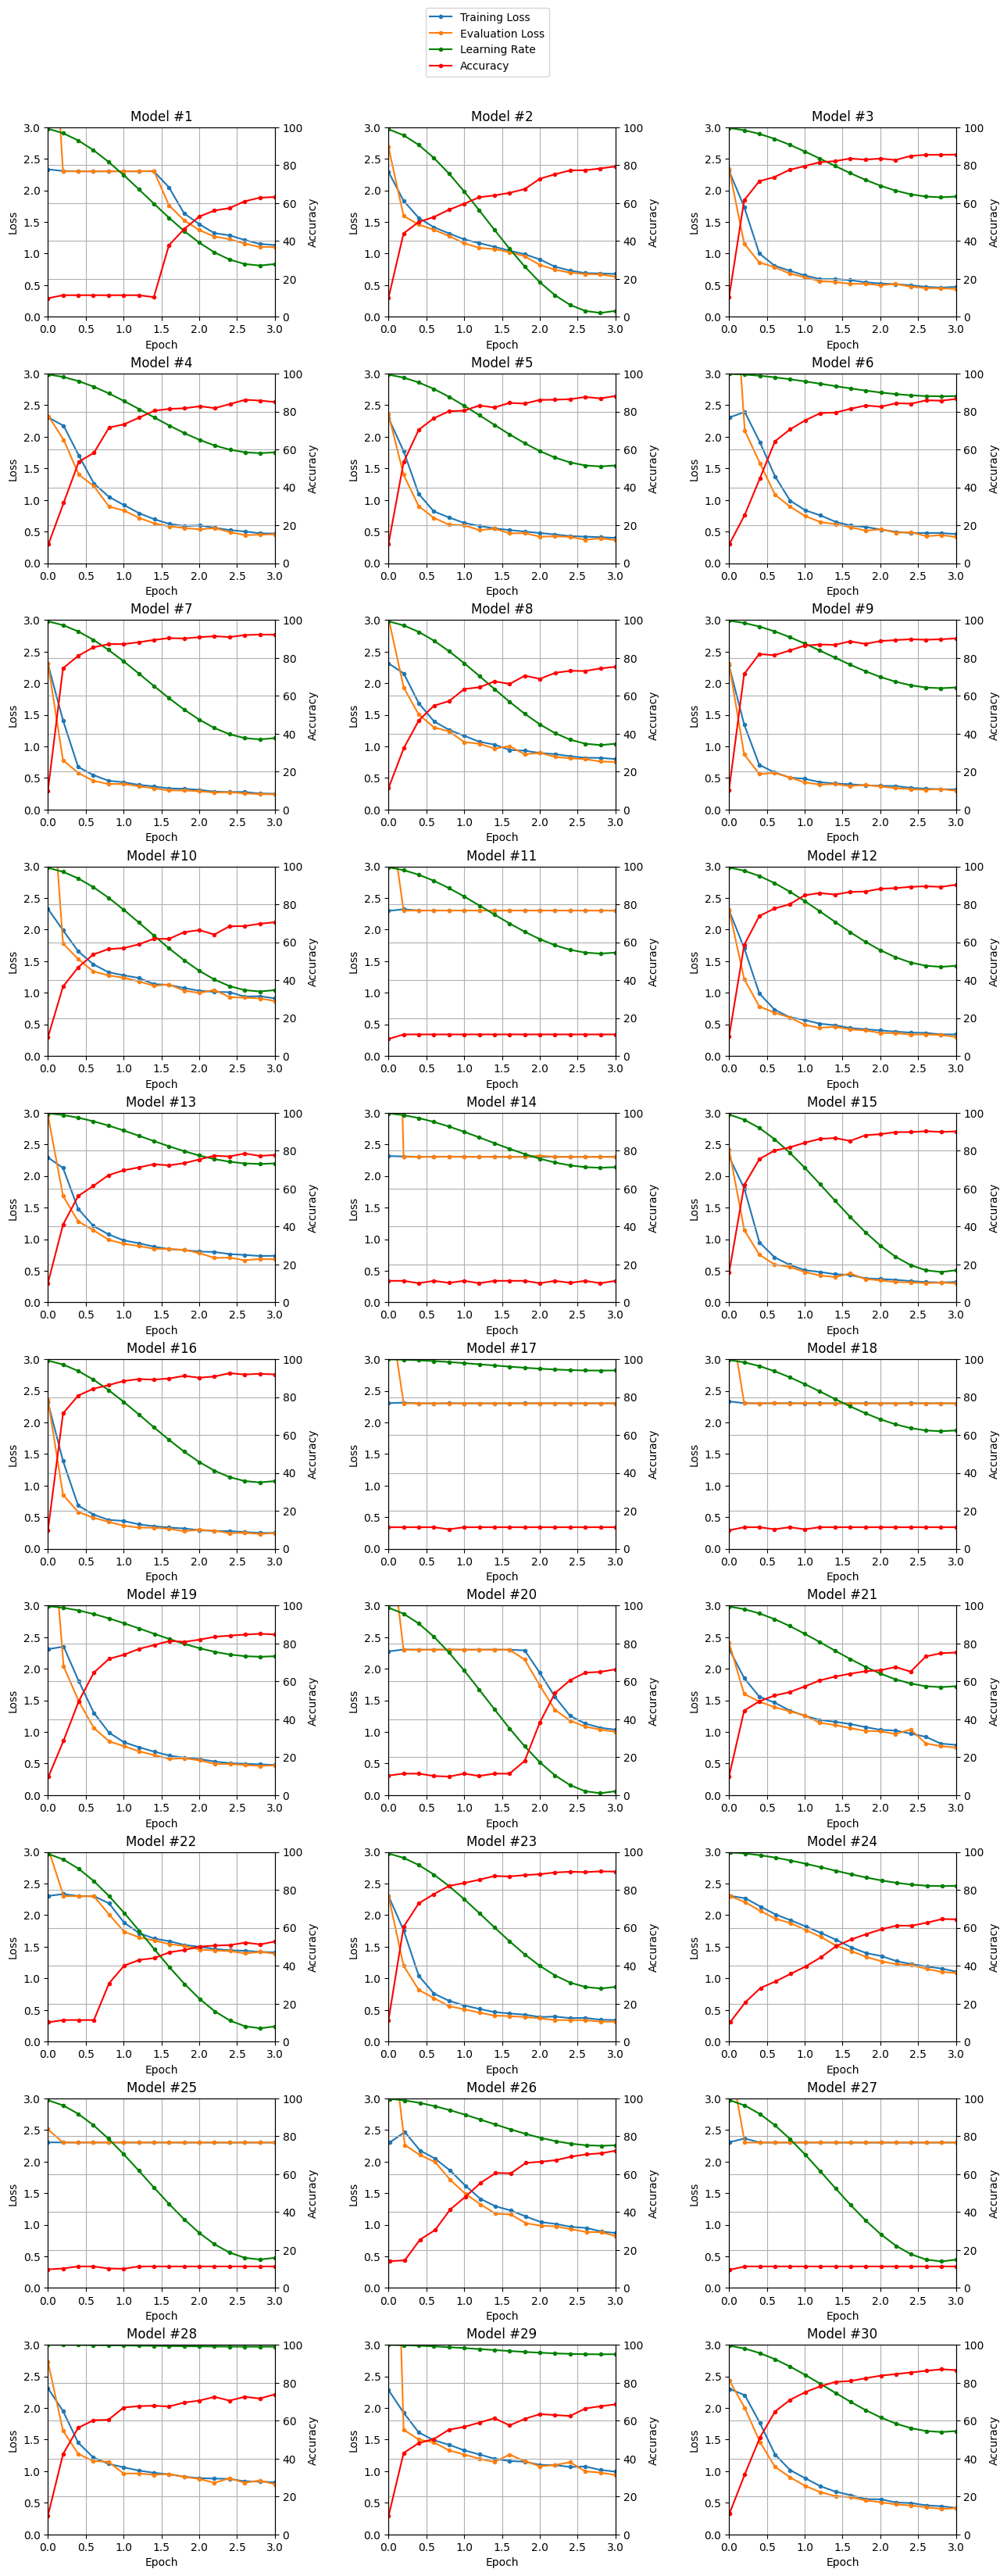

In [5]:

results = random_search(
    ParamGrid(
        # smaller batch sizes perform better
        batch_size=[5, 10, 25, 50, 100, 500, 1000],
        epochs=[3],
        # anything above 0.008 or below 0.0001 performs poorly
        starting_learning_rate=[x * 1e-4 for x in range(1, 70)],
        ending_learning_rate_ratio=[x * 0.01 for x in range(1, 100)],
        # performance degrades with higher weight decay
        weight_decay=[1e-3, 5e-4, 1e-4] + [x * 1e-5 for x in range(1, 10)],
        dropout=[x * 0.01 for x in range(1, 50)],
    ),
    max_trains=30,
)